# MapSeg Eval Tools

## Installation from Pip

```sh
pip install coco-pano-ext-demo
```

## COCO Metrics in a bipartite graph framework

Even if the primary purpose of the COCO is to score segmentations, we use a graph framework, and so we aim at scoring a bipartite graph P ↔ Q with degree 1 (1 node in P is paired with at most 1 node in Q).
The edge are weighted by a shape matching metric: the IoU. The figure below shows two segmentations and the corresponding bipartite graph to assess.

<img src="doc/matching.png" width="50%"/> <img src="doc/bipartite-5.png" width="40%" />

In [9]:
from coco_pano_ext_demo import COCO

P = [0.7, 0.6, 0.93, 0.8]
Q = [0, 0.6, 0.8, 0.7, 0.93]
PQ, SQ, RQ, _ = COCO(P, Q, ignore_zero=False)

print(
    f"""
    The Panoptic Quality is: {PQ}
    The Segmentation Quality is: {SQ}
    The Recognition Quality is: {RQ}
    """
    )



    The Panoptic Quality is: 0.6733333333333332
    The Segmentation Quality is: 0.7575
    The Recognition Quality is: 0.8888888888888888
    


## Plotting Precision/Recall and F-Score Curves

We first need to output the precision/recall table of the system as the IoU tolerance threshold increases. This is mostly the same code as previously but with the extra parameter `output_scores=True`.   

In [11]:
from coco_pano_ext_demo import COCO_plot

PQ, SQ, RQ, score_table = COCO(P, Q, ignore_zero=False, output_scores=True)
score_table

,IoU,Precision,Recall,F-score
0,0.60,0.8,1.00,0.888889
1,0.70,0.6,0.75,0.666667
2,0.80,0.4,0.50,0.444444
3,0.93,0.2,0.25,0.222222


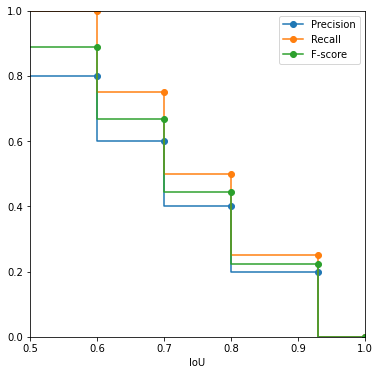

In [3]:
COCO_plot(score_table)

## COCO metrics from segmentation images and labelmaps

While the evaluation framework is graph-based, the function enables assessing directly the quality of segmentations from images. You can provide either:

* 2D labelmaps: images with labels where each component is labeled by integers (the background component should have label 0 to be ignored afterward with the parameter `ignore_zero=True`).
* 2D binary images: images with values 0 and 1, where the 4-connected regions are in white and separated by 8-connected black boundaries.

<img src="doc/296_5000_6500_5500_7000_gt.png" width="256px" /> <img src="doc/296_5000_6500_5500_7000_pred.png" width="256px" />



    The Panoptic Quality is: 0.443018795575248
    The Segmentation Quality is: 0.886037591150496
    The Recognition Quality is: 0.5
    


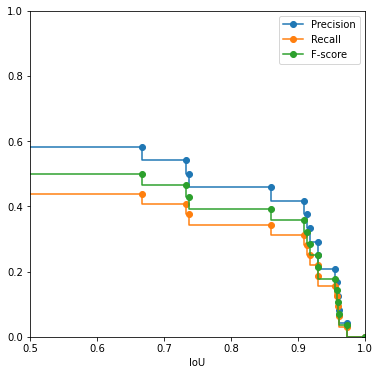

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

T = imread("doc/296_5000_6500_5500_7000_gt.png", as_gray=True)
P = imread("doc/296_5000_6500_5500_7000_pred.png", as_gray=True)


## threshold
T = np.asarray(T < 0.5)
P = np.asarray(P < 0.5)
PQ, SQ, RQ, score_table = COCO(P, T, ignore_zero=True, output_scores=True)
print(
    f"""
    The Panoptic Quality is: {PQ}
    The Segmentation Quality is: {SQ}
    The Recognition Quality is: {RQ}
    """
    )
COCO_plot(score_table)



It is also possible to be more restrictive about the "matching rate". IoU=50% might be not restrictive enough, and you may not want to consider these pairings. The parameter ``pairing_threshold`` allows filtering out edges that do not meet the required matching quality.    


    The Panoptic Quality is: 0.36671881695056546
    The Segmentation Quality is: 0.9334660795105303
    The Recognition Quality is: 0.39285714285714285
    


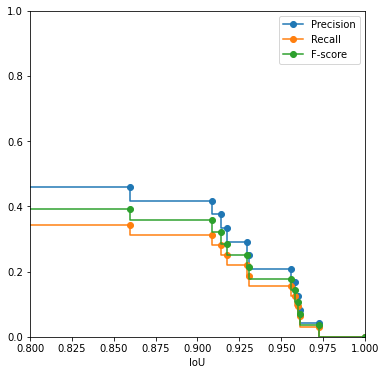

In [5]:
PQ, SQ, RQ, score_table = COCO(P, T, ignore_zero=True, output_scores=True, pairing_threshold=0.8)
print(
    f"""
    The Panoptic Quality is: {PQ}
    The Segmentation Quality is: {SQ}
    The Recognition Quality is: {RQ}
    """
    )
COCO_plot(score_table, lower_bound=0.8)

## Precision/Recall Maps

Precision/recall maps provide a visual insight about the performances of a system. Every non-green region in one of the map means that the region does not match correctly between the groundtruth and the prediction.

In particular, they highlight:

* the regions that have been missed (Miss) that appear in red in the *Recall map*
* the regions that have been over-segmented (False Alarm) that appear in red in the *Precision Map* 

An extra parameter, the *acceptance threshold*, allows to center the colormap to a given acceptance score.

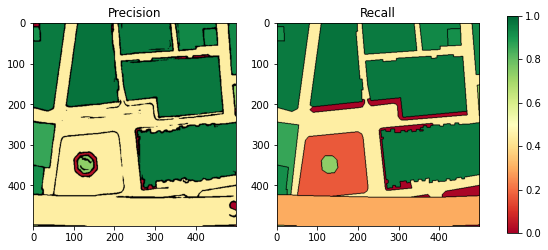

In [6]:
from skimage.io import imread
import coco_pano_ext_demo as coco
import matplotlib.cm

GT = imread("doc/296_5000_6500_5500_7000_gt.png", as_gray=True)
Pred = imread("doc/296_5000_6500_5500_7000_pred.png", as_gray=True)
GT = GT < 0.5
Pred = Pred < 0.5

def show_precision_recall(t):
    precision, recall = coco.precision_recall_maps(GT, Pred, lower_bound=t)

    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))
    ax1.imshow(precision)
    ax1.set_title("Precision")
    ax2.imshow(recall)
    ax2.set_title("Recall")
    f.colorbar(matplotlib.cm.ScalarMappable(cmap=coco._cmap), ax=[ax1, ax2])

show_precision_recall(t = 0.5)


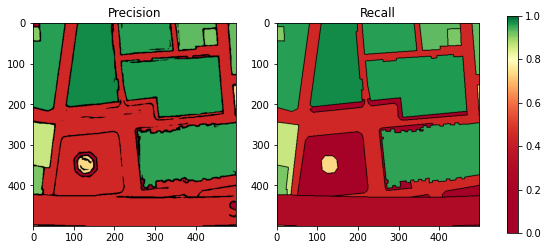

In [7]:
show_precision_recall(t = 0.8)